In [1]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv \
  -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

!pip install torch-geometric

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
Looking in indexes: http://mirrors.aliyun.com/pypi/simple


#Binary Link Prediction for Polypharmacy Side Effects Using R-GCN

In [2]:

# STEP 1: Mount Google Drive to access files
#from google.colab import drive
#drive.mount('/content/drive')

# STEP 2: Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import networkx as nx
import tarfile

#step 3
import pandas as pd
# Load the CSV (comma separated)
base_path = "/root/autodl-tmp/FinalProjectRemote/Graph Model/"
path = base_path + "bio-decagon-combo.csv"
# Read first four columns
df = pd.read_csv(path)
combo = df[['STITCH 1', 'STITCH 2', 'Polypharmacy Side Effect']]
combo.columns = ['drug1', 'drug2', 'side_effect']

# Check first few rows
combo.head()

,drug1,drug2,side_effect
0,CID000002173,CID000003345,C0151714
1,CID000002173,CID000003345,C0035344
2,CID000002173,CID000003345,C0004144
3,CID000002173,CID000003345,C0002063
4,CID000002173,CID000003345,C0004604


In [3]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Reading Data
base_path = "/root/autodl-tmp/FinalProjectRemote/Graph Model/"
path = base_path + "bio-decagon-combo.csv"
df = pd.read_csv(path)

combo = df[['STITCH 1', 'STITCH 2', 'Polypharmacy Side Effect']].copy()
combo.columns = ['drug1', 'drug2', 'side_effect']

counts = combo['side_effect'].value_counts()
common_se = counts[counts >= 500].index
combo = combo[combo['side_effect'].isin(common_se)]
print(f'Filtered dataset: {len(common_se)} side effects (>=500), {len(combo)} triples.')

# Only retain side_effects with occurrence frequency ≥2 to reduce extremely rare noise.
rel_counts = combo['side_effect'].value_counts()
valid_rels = rel_counts[rel_counts >= 2].index
combo = combo[combo['side_effect'].isin(valid_rels)].reset_index(drop=True)

# Drug Mapping
drug_list = pd.unique(combo[['drug1','drug2']].values.ravel())
drug2id = {d:i for i,d in enumerate(drug_list)}
num_nodes = len(drug_list)

# binary
pos_edges = combo[['drug1','drug2']].drop_duplicates()
pos_u = pos_edges['drug1'].map(drug2id).to_numpy()
pos_v = pos_edges['drug2'].map(drug2id).to_numpy()
pos_edges_np = np.stack([pos_u, pos_v], axis=1)

# Treat edges as undirected: Add reverse direction
pos_edges_np = np.concatenate([pos_edges_np, pos_edges_np[:, ::-1]], axis=0)

# Train/Test Split (by Edge)
idx = np.arange(len(pos_edges_np))
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42)

pos_train = pos_edges_np[train_idx]
pos_test  = pos_edges_np[test_idx]

# Training graph uses only pos_train (to prevent test edges from leaking into message passing)
train_edge_index = torch.tensor(pos_train.T, dtype=torch.long)  # [2, E_train]

combo.head()

Filtered dataset: 963 side effects (>=500), 4576287 triples.


,drug1,drug2,side_effect
0,CID000002173,CID000003345,C0004144
1,CID000002173,CID000003345,C0004604
2,CID000002173,CID000003345,C0034063
3,CID000002173,CID000003345,C0085631
4,CID000002173,CID000003345,C0013384


In [4]:
def build_edge_set(edges_np):
    return set((int(u), int(v)) for u,v in edges_np)

pos_set = build_edge_set(pos_edges_np)

def negative_sampling(num_nodes, num_samples, forbidden_set, seed=0):
    rng = np.random.default_rng(seed)
    neg = []
    while len(neg) < num_samples:
        u = rng.integers(0, num_nodes)
        v = rng.integers(0, num_nodes)
        if u == v:
            continue
        if (int(u), int(v)) in forbidden_set:
            continue
        neg.append((int(u), int(v)))
    return np.array(neg, dtype=np.int64)

# The number of negative samples in training/testing is typically set equal to that of positive samples (1:1).
neg_train = negative_sampling(num_nodes, len(pos_train), pos_set, seed=1)
neg_test  = negative_sampling(num_nodes, len(pos_test),  pos_set, seed=2)

pos_train_t = torch.tensor(pos_train, dtype=torch.long)
neg_train_t = torch.tensor(neg_train, dtype=torch.long)
pos_test_t  = torch.tensor(pos_test,  dtype=torch.long)
neg_test_t  = torch.tensor(neg_test,  dtype=torch.long)


In [5]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device =", device)

class RGCNEncoder(nn.Module):
    def __init__(self, num_nodes, emb_dim=64, hidden_dim=64, num_layers=2, num_relations=1, num_bases=16):
        super().__init__()
        self.emb = nn.Embedding(num_nodes, emb_dim)
        self.convs = nn.ModuleList()
        in_dim = emb_dim
        for _ in range(num_layers):
            self.convs.append(RGCNConv(in_dim, hidden_dim, num_relations=num_relations, num_bases=num_bases))
            in_dim = hidden_dim
        self.out_dim = hidden_dim

    def forward(self, edge_index, edge_type):
        x = self.emb.weight
        for conv in self.convs:
            x = conv(x, edge_index, edge_type)
            x = F.relu(x)
        return x

class DotDecoder(nn.Module):
    def forward(self, z, pairs):  # pairs: [B,2]
        u, v = pairs[:,0], pairs[:,1]
        return (z[u] * z[v]).sum(dim=-1)  # logits

class RGCNLinkPredictor(nn.Module):
    def __init__(self, num_nodes, emb_dim=64, hidden_dim=64):
        super().__init__()
        self.enc = RGCNEncoder(num_nodes, emb_dim=emb_dim, hidden_dim=hidden_dim, num_layers=2, num_relations=1)
        self.dec = DotDecoder()

    def forward(self, edge_index, edge_type, pairs):
        z = self.enc(edge_index, edge_type)
        logits = self.dec(z, pairs)
        return logits, z

model = RGCNLinkPredictor(num_nodes, emb_dim=64, hidden_dim=64).to(device)

# Binary graph: Only one type of relation exists, so all edge_type values are 0.
train_edge_type = torch.zeros(train_edge_index.size(1), dtype=torch.long)

train_edge_index = train_edge_index.to(device)
train_edge_type  = train_edge_type.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss()

/root/miniconda3/lib/python3.12/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /root/miniconda3/lib/python3.12/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  import torch_geometric.typing
/root/miniconda3/lib/python3.12/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /root/miniconda3/lib/python3.12/site-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  import torch_geometric.typing
/root/miniconda3/lib/python3.12/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /root/miniconda3/lib/python3.12/site-packages/torch_spline_conv/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
 

device = cuda


In [6]:
from sklearn.metrics import roc_auc_score, average_precision_score

def get_metrics(model, edge_index, edge_type, pos_pairs, neg_pairs):
    model.eval()
    with torch.no_grad():
        pos_logits, _ = model(edge_index, edge_type, pos_pairs)
        neg_logits, _ = model(edge_index, edge_type, neg_pairs)
        logits = torch.cat([pos_logits, neg_logits], dim=0).detach().cpu().numpy()
        y = np.concatenate([np.ones(len(pos_pairs)), np.zeros(len(neg_pairs))])
        auroc = roc_auc_score(y, logits)
        aupr  = average_precision_score(y, logits)
        return auroc, aupr

pos_train_d = pos_train_t.to(device)
neg_train_d = neg_train_t.to(device)
pos_test_d  = pos_test_t.to(device)
neg_test_d  = neg_test_t.to(device)

epochs = 20
batch_size = 4096

def train_one_epoch():
    model.train()
    # Build a training batch: positive + negative
    pairs = torch.cat([pos_train_d, neg_train_d], dim=0)
    labels = torch.cat([torch.ones(len(pos_train_d)), torch.zeros(len(neg_train_d))], dim=0).to(device)

    # shuffle
    perm = torch.randperm(pairs.size(0), device=device)
    pairs = pairs[perm]
    labels = labels[perm]

    total_loss = 0.0
    for i in range(0, pairs.size(0), batch_size):
        b_pairs = pairs[i:i+batch_size]
        b_labels = labels[i:i+batch_size]

        optimizer.zero_grad()
        logits, _ = model(train_edge_index, train_edge_type, b_pairs)
        loss = criterion(logits, b_labels)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * b_pairs.size(0)

    return total_loss / pairs.size(0)

for ep in range(1, epochs + 1):
    loss = train_one_epoch()
    train_auroc, train_aupr = get_metrics(model, train_edge_index, train_edge_type, pos_train_d, neg_train_d)
    test_auroc,  test_aupr  = get_metrics(model, train_edge_index, train_edge_type, pos_test_d,  neg_test_d)

    if ep == epochs:
        print(
            f"Final Epoch | "
            f"loss={loss:.4f} | "
            f"train_AUROC={train_auroc:.4f} train_AUPR={train_aupr:.4f} | "
            f"test_AUROC={test_auroc:.4f} test_AUPR={test_aupr:.4f}"
        )


/tmp/ipykernel_50980/1318678515.py:43: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  total_loss += float(loss) * b_pairs.size(0)


Final Epoch | loss=0.5089 | train_AUROC=0.8569 train_AUPR=0.8736 | test_AUROC=0.8579 test_AUPR=0.8746


(645, 64)


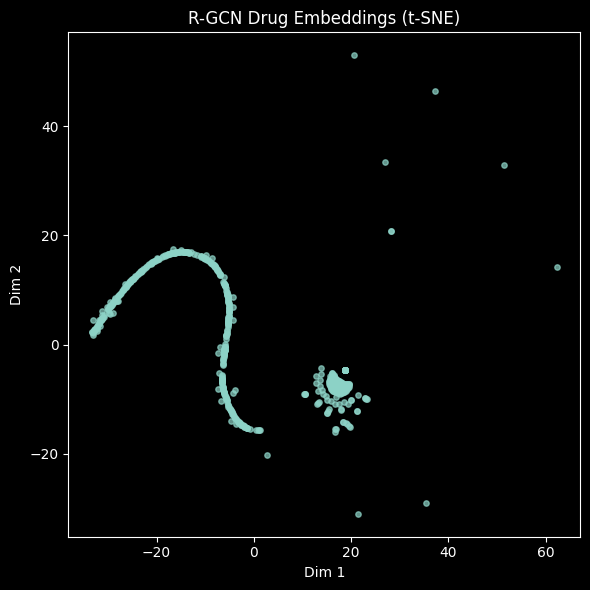

In [7]:
model.eval()
with torch.no_grad():
    Z = model.enc(train_edge_index, train_edge_type)   # [num_drugs, d]

Z = Z.cpu().numpy()
print(Z.shape)

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="random",
    random_state=42
)

Z_2d = tsne.fit_transform(Z)
plt.figure(figsize=(6, 6))
plt.scatter(Z_2d[:, 0], Z_2d[:, 1], s=15, alpha=0.7)
plt.title("R-GCN Drug Embeddings (t-SNE)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
plt.show()

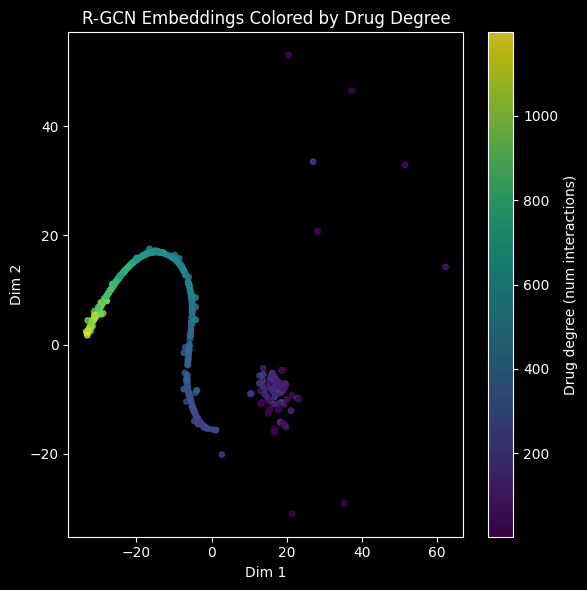

In [8]:
import numpy as np

edges = np.unique(pos_edges_np, axis=0)   # 去重

deg = np.zeros(num_nodes, dtype=int)
np.add.at(deg, edges[:,0], 1)
np.add.at(deg, edges[:,1], 1)

# Then draw the diagram (Z_2d already exists)
plt.figure(figsize=(6,6))
sc = plt.scatter(Z_2d[:,0], Z_2d[:,1], c=deg, s=15, alpha=0.8)
plt.colorbar(sc, label="Drug degree (num interactions)")
plt.title("R-GCN Embeddings Colored by Drug Degree")
plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
plt.tight_layout()
plt.show()

Multi-class Classification of Polypharmacy Side Effects Using R-GCN (Top-K Frequent Side Effects)

In [9]:
import os, random, numpy as np, pandas as pd, torch
from sklearn.model_selection import train_test_split

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device =", device)

# Reading Decagon Combo
base_path = "/root/autodl-tmp/FinalProjectRemote/Graph Model/"
path = base_path + "bio-decagon-combo.csv"
df = pd.read_csv(path)

combo = df[['STITCH 1', 'STITCH 2', 'Polypharmacy Side Effect']].copy()
combo.columns = ['drug1','drug2','side_effect']

# Hierarchical mapping (side effect code -> disease class)
map_file = base_path + "bio-decagon-effectcategories.csv"
df_map = pd.read_csv(map_file)
FINE_GRAINED_COL = 'Side Effect'
COARSE_GRAINED_COL = 'Disease Class'
side_effect_to_parent_map = pd.Series(
    df_map[COARSE_GRAINED_COL].values,
    index=df_map[FINE_GRAINED_COL]
).to_dict()
print(f"hierarchical map size: {len(side_effect_to_parent_map)}")


# Filter: Side effects occurring ≥ 2 times (otherwise split would have single-sample classes)
rel_counts = combo['side_effect'].value_counts()
valid_rels = rel_counts[rel_counts >= 2].index
combo = combo[combo['side_effect'].isin(valid_rels)].reset_index(drop=True)

print("rows after filter:", len(combo))
print("num classes:", combo['side_effect'].nunique())

MAX_EDGES = 200_000
if len(combo) > MAX_EDGES:
    combo = combo.sample(n=MAX_EDGES, random_state=SEED).reset_index(drop=True)
print("rows used:", len(combo))

#  ID Mapping
drug_list = pd.unique(pd.concat([combo['drug1'], combo['drug2']], axis=0))
drug2id = {d:i for i,d in enumerate(drug_list)}
id2drug = {i:d for d,i in drug2id.items()}
num_nodes = len(drug2id)

rels = combo['side_effect'].unique()
rel2id = {r:i for i,r in enumerate(rels)}
id2rel = {i:r for r,i in rel2id.items()}
num_rels = len(rel2id)

combo['head'] = combo['drug1'].map(drug2id).astype(int)
combo['tail'] = combo['drug2'].map(drug2id).astype(int)
combo['rel']  = combo['side_effect'].map(rel2id).astype(int)

# Sampling
MAX_EDGES = 200_000
if len(combo) > MAX_EDGES:
    combo = combo.sample(n=MAX_EDGES, random_state=SEED).reset_index(drop=True)

# Filter again
rel_counts = combo['side_effect'].value_counts()
valid_rels = rel_counts[rel_counts >= 2].index
combo = combo[combo['side_effect'].isin(valid_rels)].reset_index(drop=True)

print("rows after re-filter:", len(combo))
print("num classes after re-filter:", combo['side_effect'].nunique())

X = combo[['head','tail']].to_numpy()
y = combo['rel'].to_numpy()

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=SEED, stratify=y_train
)

print("train/val/test:", len(X_train), len(X_val), len(X_test))
print("num_nodes:", num_nodes, "num_rels:", num_rels)


device = cuda
hierarchical map size: 561
rows after filter: 4649440
num classes: 1316
rows used: 200000
rows after re-filter: 199983
num classes after re-filter: 1267
train/val/test: 143987 15999 39997
num_nodes: 642 num_rels: 1284


In [10]:

import torch
from torch_geometric.data import Data

# 只用 train 边构建 message passing 图（避免 test leakage）
train_heads = torch.tensor(X_train[:,0], dtype=torch.long)
train_tails = torch.tensor(X_train[:,1], dtype=torch.long)
train_rels  = torch.tensor(y_train,     dtype=torch.long)

# PyG 的 edge_index: [2, E]
edge_index = torch.stack([train_heads, train_tails], dim=0)
edge_type  = train_rels  # [E]
rev_edge_index = torch.stack([train_tails, train_heads], dim=0)
edge_index = torch.cat([edge_index, rev_edge_index], dim=1)
edge_type = torch.cat([edge_type, edge_type], dim=0)

data = Data(
    num_nodes=num_nodes,
    edge_index=edge_index,
    edge_type=edge_type
).to(device)

print(data)


Data(edge_index=[2, 287974], num_nodes=642, edge_type=[287974])


In [11]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv

class RGCNEncoder(nn.Module):
    def __init__(self, num_nodes, num_rels, emb_dim=64, hidden_dim=64, out_dim=64, num_layers=2, dropout=0.2, num_bases=32):
        super().__init__()
        num_bases = min(num_bases, num_rels)
        self.node_emb = nn.Embedding(num_nodes, emb_dim)

        self.convs = nn.ModuleList()
        dims = [emb_dim] + [hidden_dim]*(num_layers-1) + [out_dim]
        for i in range(num_layers):
            self.convs.append(RGCNConv(
                in_channels=dims[i],
                out_channels=dims[i+1],
                num_relations=num_rels, num_bases=num_bases))
        self.dropout = dropout

    def forward(self, edge_index, edge_type):
        x = self.node_emb.weight
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index, edge_type)
            if i != len(self.convs)-1:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
        return x  # [num_nodes, out_dim]

class PairClassifier(nn.Module):
    def __init__(self, dim, num_classes, hidden=128, dropout=0.2):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(dim*4, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, num_classes)
        )

    def forward(self, z, heads, tails):
        zh = z[heads]
        zt = z[tails]
        feat = torch.cat([zh, zt, zh*zt, torch.abs(zh-zt)], dim=-1)
        return self.mlp(feat)  # [B, num_classes]

emb_dim = 64
hidden_dim = 64
out_dim = 64
num_layers = 2
dropout = 0.2

encoder = RGCNEncoder(num_nodes, num_rels, emb_dim, hidden_dim, out_dim, num_layers, dropout).to(device)
clf = PairClassifier(out_dim, num_rels, hidden=128, dropout=dropout).to(device)

params = list(encoder.parameters()) + list(clf.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

print("model ready.")


model ready.


In [12]:
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score

class PairDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(PairDataset(X_train, y_train), batch_size=2048, shuffle=True, drop_last=False)
val_loader   = DataLoader(PairDataset(X_val,   y_val),   batch_size=4096, shuffle=False)
test_loader  = DataLoader(PairDataset(X_test,  y_test),  batch_size=4096, shuffle=False)

@torch.no_grad()
def evaluate(loader, ks=(1,5,10)):
    encoder.eval(); clf.eval()

    # full-graph embedding once (eval阶段这样做没问题)
    z = encoder(data.edge_index, data.edge_type)

    all_y = []
    all_pred = []
    all_prob = []

    # top-k accumulators
    topk_hits = {k: 0.0 for k in ks}
    n_total = 0

    for (pair, yb) in loader:
        pair = pair.to(device)
        yb = yb.to(device)
        heads = pair[:,0]
        tails = pair[:,1]

        logits = clf(z, heads, tails)              # [B, C]
        prob = F.softmax(logits, dim=-1)           # [B, C]

        # top-k
        tk = topk_accuracy_from_logits(logits, yb, ks=ks)
        bsz = yb.size(0)
        for k in ks:
            topk_hits[k] += tk[k] * bsz
        n_total += bsz

        all_y.append(yb.detach().cpu().numpy())
        all_pred.append(prob.argmax(dim=-1).detach().cpu().numpy())
        all_prob.append(prob.detach().cpu().numpy())

    y_true = np.concatenate(all_y)
    y_pred = np.concatenate(all_pred)
    y_prob = np.concatenate(all_prob)

    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_micro = f1_score(y_true, y_pred, average='micro')

    # safe AUROC/AUPR on present classes only
    try:
        auroc_macro = safe_macro_auroc_subset(y_true, y_prob)
        auroc_micro = safe_micro_auroc_subset(y_true, y_prob)
    except Exception as e:
        print("AUROC failed:", e)
        auroc_macro = np.nan
        auroc_micro = np.nan

    try:
        aupr_macro = safe_macro_aupr_subset(y_true, y_prob)
        aupr_micro = safe_micro_aupr_subset(y_true, y_prob)
    except Exception as e:
        print("AUPR failed:", e)
        aupr_macro = np.nan
        aupr_micro = np.nan

    # AP@50 (for multi-class this reduces to 1/rank if in top-50 else 0)
    y_true_onehot = np.zeros_like(y_prob, dtype=np.int32)
    y_true_onehot[np.arange(y_true.shape[0]), y_true] = 1
    ap50 = mean_ap_at_k(y_true_onehot, y_prob, k=50)

    topk = {k: topk_hits[k] / n_total for k in ks}

    return acc, f1_macro, f1_micro, auroc_macro, auroc_micro, aupr_macro, aupr_micro, ap50, topk

def train_one_epoch():
    encoder.train()
    clf.train()
    total_loss = 0.0


    for pair, yb in train_loader:
        pair = pair.to(device)
        yb = yb.to(device)
        heads = pair[:, 0]
        tails = pair[:, 1]

        optimizer.zero_grad(set_to_none=True)

        z = encoder(data.edge_index, data.edge_type)
        logits = clf(z, heads, tails)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(yb)

    return total_loss / len(train_loader.dataset)


In [13]:
@torch.no_grad()
def topk_accuracy_from_logits(logits: torch.Tensor, y_true: torch.Tensor, ks=(1,5,10)):
    """
    logits: [B, C]
    y_true: [B]
    return: dict {k: topk_acc}
    """
    maxk = max(ks)
    # topk indices: [B, maxk]
    topk = logits.topk(k=maxk, dim=1).indices
    # compare: [B, maxk]
    correct = topk.eq(y_true.view(-1, 1))
    out = {}
    for k in ks:
        out[k] = correct[:, :k].any(dim=1).float().mean().item()
    return out

In [14]:
from sklearn.preprocessing import label_binarize

def _binarize_present_classes(y_true: np.ndarray, y_prob: np.ndarray):
    """
    Returns (y_true_bin, y_prob_sub) restricted to classes present in y_true.
    y_true_bin: [N, |present|]
    y_prob_sub: [N, |present|]
    """
    present = np.unique(y_true)
    if len(present) < 2:
        return None
    y_true_bin = label_binarize(y_true, classes=present)
    y_prob_sub = y_prob[:, present]
    if y_true_bin.ndim != 2 or y_true_bin.shape[1] < 2:
        return None
    return y_true_bin, y_prob_sub

def safe_macro_auroc_subset(y_true: np.ndarray, y_prob: np.ndarray):
    """
    y_true: [N] int labels
    y_prob: [N, C] softmax probabilities over ALL classes
    Only evaluate AUROC over classes that actually appear in y_true.
    """
    out = _binarize_present_classes(y_true, y_prob)
    if out is None:
        return np.nan
    y_true_bin, y_prob_sub = out
    return roc_auc_score(y_true_bin, y_prob_sub, average="macro")

def safe_micro_auroc_subset(y_true: np.ndarray, y_prob: np.ndarray):
    out = _binarize_present_classes(y_true, y_prob)
    if out is None:
        return np.nan
    y_true_bin, y_prob_sub = out
    return roc_auc_score(y_true_bin, y_prob_sub, average="micro")

def safe_macro_aupr_subset(y_true: np.ndarray, y_prob: np.ndarray):
    out = _binarize_present_classes(y_true, y_prob)
    if out is None:
        return np.nan
    y_true_bin, y_prob_sub = out
    return average_precision_score(y_true_bin, y_prob_sub, average="macro")

def safe_micro_aupr_subset(y_true: np.ndarray, y_prob: np.ndarray):
    out = _binarize_present_classes(y_true, y_prob)
    if out is None:
        return np.nan
    y_true_bin, y_prob_sub = out
    return average_precision_score(y_true_bin, y_prob_sub, average="micro")

def mean_ap_at_k(y_true_bin: np.ndarray, y_scores: np.ndarray, k: int = 50) -> float:
    """
    y_true_bin: (N, C) multi-hot labels
    y_scores:   (N, C) scores/probabilities
    """
    n_samples, n_classes = y_true_bin.shape
    if n_samples == 0 or n_classes == 0:
        return float('nan')
    k = min(k, n_classes)

    ap_sum = 0.0
    for i in range(n_samples):
        gt = np.flatnonzero(y_true_bin[i])
        if gt.size == 0:
            continue
        gt_set = set(gt.tolist())

        scores = y_scores[i]
        if k < scores.shape[0]:
            ind = np.argpartition(scores, -k)[-k:]
            ind = ind[np.argsort(scores[ind])[::-1]]
        else:
            ind = np.argsort(scores)[::-1][:k]

        hits = 0
        sum_prec = 0.0
        for rank, idx in enumerate(ind, start=1):
            if int(idx) in gt_set:
                hits += 1
                sum_prec += hits / rank
        ap_sum += sum_prec / min(len(gt_set), k)

    return ap_sum / n_samples

In [15]:

print("\n[PHASE 1] Multi-class (original side effects)")

EPOCHS = 20
best_val = -1
best_state = None

for epoch in range(1, EPOCHS+1):
    loss = train_one_epoch()
    val_acc, val_f1_macro, val_f1_micro, val_auroc_macro, val_auroc_micro, val_aupr_macro, val_aupr_micro, val_ap50, val_topk = evaluate(val_loader, ks=(1,5,10))
    print(f"Epoch {epoch:02d} | loss={loss:.4f} | "
          f"val@1={val_topk[1]:.4f} val@5={val_topk[5]:.4f} val@10={val_topk[10]:.4f} | "
          f"f1(micro)={val_f1_micro:.4f} f1(macro)={val_f1_macro:.4f} | "
          f"auroc(micro)={val_auroc_micro:.4f} auroc(macro)={val_auroc_macro:.4f} | "
          f"aucpr(micro)={val_aupr_micro:.4f} aucpr(macro)={val_aupr_macro:.4f} | "
          f"ap@50={val_ap50:.4f}")

    score = val_ap50
    if score > best_val:
        best_val = score
        best_state = {
            "encoder": {k:v.detach().cpu() for k,v in encoder.state_dict().items()},
            "clf": {k:v.detach().cpu() for k,v in clf.state_dict().items()}
        }

# load best
if best_state is not None:
    encoder.load_state_dict({k:v.to(device) for k,v in best_state["encoder"].items()})
    clf.load_state_dict({k:v.to(device) for k,v in best_state["clf"].items()})

test_acc, test_f1_macro, test_f1_micro, test_auroc_macro, test_auroc_micro, test_aupr_macro, test_aupr_micro, test_ap50, test_topk = evaluate(test_loader, ks=(1,5,10))
print("\n=== TEST ===")
print(f"top1={test_topk[1]:.4f} | top5={test_topk[5]:.4f} | top10={test_topk[10]:.4f} | "
      f"f1(micro)={test_f1_micro:.4f} f1(macro)={test_f1_macro:.4f} | "
      f"auroc(micro)={test_auroc_micro:.4f} auroc(macro)={test_auroc_macro:.4f} | "
      f"aucpr(micro)={test_aupr_micro:.4f} aucpr(macro)={test_aupr_macro:.4f} | "
      f"ap@50={test_ap50:.4f}")

print("\n[PHASE 2] Multi-class (hierarchical mapping: Disease Class)")

# Build hierarchical labels on the same sampled combo
combo_h = combo.copy()
combo_h['side_effect_coarse'] = combo_h['side_effect'].map(side_effect_to_parent_map).fillna(combo_h['side_effect'])

# Filter coarse classes with >= 2 occurrences
coarse_counts = combo_h['side_effect_coarse'].value_counts()
valid_coarse = coarse_counts[coarse_counts >= 2].index
combo_h = combo_h[combo_h['side_effect_coarse'].isin(valid_coarse)].reset_index(drop=True)

print("num coarse classes:", combo_h['side_effect_coarse'].nunique())

# Rebuild relation ids for coarse labels
rels_h = combo_h['side_effect_coarse'].unique()
rel2id_h = {r:i for i,r in enumerate(rels_h)}
num_rels = len(rel2id_h)

combo_h['rel'] = combo_h['side_effect_coarse'].map(rel2id_h).astype(int)
X = combo_h[['head','tail']].to_numpy()
y = combo_h['rel'].to_numpy()

# split (stratify on coarse labels)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=SEED, stratify=y_train
)

# Update loaders (reuse PairDataset)
train_loader = DataLoader(PairDataset(X_train, y_train), batch_size=2048, shuffle=True, drop_last=False)
val_loader   = DataLoader(PairDataset(X_val,   y_val),   batch_size=4096, shuffle=False)
test_loader  = DataLoader(PairDataset(X_test,  y_test),  batch_size=4096, shuffle=False)

# Rebuild message passing graph with train edges only
train_heads = torch.tensor(X_train[:,0], dtype=torch.long)
train_tails = torch.tensor(X_train[:,1], dtype=torch.long)
train_rels  = torch.tensor(y_train,     dtype=torch.long)
edge_index = torch.stack([train_heads, train_tails], dim=0)
edge_type  = train_rels
rev_edge_index = torch.stack([train_tails, train_heads], dim=0)
edge_index = torch.cat([edge_index, rev_edge_index], dim=1)
edge_type = torch.cat([edge_type, edge_type], dim=0)

data = Data(num_nodes=num_nodes, edge_index=edge_index, edge_type=edge_type).to(device)

# Re-init model/optimizer for new num_rels
encoder = RGCNEncoder(num_nodes, num_rels, emb_dim, hidden_dim, out_dim, num_layers, dropout).to(device)
clf = PairClassifier(out_dim, num_rels, hidden=128, dropout=dropout).to(device)
params = list(encoder.parameters()) + list(clf.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

# Train/eval (same loop as Phase 1)
best_val = -1
best_state = None
for epoch in range(1, EPOCHS+1):
    loss = train_one_epoch()
    val_acc, val_f1_macro, val_f1_micro, val_auroc_macro, val_auroc_micro, val_aupr_macro, val_aupr_micro, val_ap50, val_topk = evaluate(val_loader, ks=(1,5,10))
    print(f"Epoch {epoch:02d} | loss={loss:.4f} | "
          f"val@1={val_topk[1]:.4f} val@5={val_topk[5]:.4f} val@10={val_topk[10]:.4f} | "
          f"f1(micro)={val_f1_micro:.4f} f1(macro)={val_f1_macro:.4f} | "
          f"auroc(micro)={val_auroc_micro:.4f} auroc(macro)={val_auroc_macro:.4f} | "
          f"aucpr(micro)={val_aupr_micro:.4f} aucpr(macro)={val_aupr_macro:.4f} | "
          f"ap@50={val_ap50:.4f}")

    score = val_ap50
    if score > best_val:
        best_val = score
        best_state = {
            "encoder": {k:v.detach().cpu() for k,v in encoder.state_dict().items()},
            "clf": {k:v.detach().cpu() for k,v in clf.state_dict().items()}
        }

if best_state is not None:
    encoder.load_state_dict({k:v.to(device) for k,v in best_state["encoder"].items()})
    clf.load_state_dict({k:v.to(device) for k,v in best_state["clf"].items()})

test_acc, test_f1_macro, test_f1_micro, test_auroc_macro, test_auroc_micro, test_aupr_macro, test_aupr_micro, test_ap50, test_topk = evaluate(test_loader, ks=(1,5,10))
print("\n=== TEST (Hierarchical) ===")
print(f"top1={test_topk[1]:.4f} | top5={test_topk[5]:.4f} | top10={test_topk[10]:.4f} | "
      f"f1(micro)={test_f1_micro:.4f} f1(macro)={test_f1_macro:.4f} | "
      f"auroc(micro)={test_auroc_micro:.4f} auroc(macro)={test_auroc_macro:.4f} | "
      f"aucpr(micro)={test_aupr_micro:.4f} aucpr(macro)={test_aupr_macro:.4f} | "
      f"ap@50={test_ap50:.4f}")



[PHASE 1] Multi-class (original side effects)
Epoch 01 | loss=9.6079 | val@1=0.0027 val@5=0.0144 val@10=0.0269 | f1(micro)=0.0027 f1(macro)=0.0003 | auroc(micro)=0.6565 auroc(macro)=0.4857 | aucpr(micro)=0.0015 aucpr(macro)=0.0014 | ap@50=0.0118
Epoch 02 | loss=6.8294 | val@1=0.0059 val@5=0.0238 val@10=0.0470 | f1(micro)=0.0059 f1(macro)=0.0002 | auroc(micro)=0.7668 auroc(macro)=0.5193 | aucpr(micro)=0.0027 aucpr(macro)=0.0014 | ap@50=0.0206
Epoch 03 | loss=6.5979 | val@1=0.0061 val@5=0.0263 val@10=0.0506 | f1(micro)=0.0061 f1(macro)=0.0001 | auroc(micro)=0.7833 auroc(macro)=0.5595 | aucpr(micro)=0.0031 aucpr(macro)=0.0020 | ap@50=0.0220
Epoch 04 | loss=6.5440 | val@1=0.0056 val@5=0.0268 val@10=0.0504 | f1(micro)=0.0056 f1(macro)=0.0001 | auroc(micro)=0.7858 auroc(macro)=0.5691 | aucpr(micro)=0.0032 aucpr(macro)=0.0022 | ap@50=0.0220
Epoch 05 | loss=6.5221 | val@1=0.0058 val@5=0.0271 val@10=0.0511 | f1(micro)=0.0058 f1(macro)=0.0001 | auroc(micro)=0.7869 auroc(macro)=0.5750 | aucpr(mi